## SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [3]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 
import math
import scipy.io as sio

In [2]:
def kalman(X_0, P_0, z, T, H, R, Q):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros((len(z),*(H.transpose().shape)))
    XF= np.zeros_like(X)
    Xp= np.zeros_like(X)
    T6 = np.linalg.matrix_power(T,6)
    for i, _ in enumerate(z):
        #Prediction
        Xp[i] = X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R)
        tmp2 = H.transpose().dot(tmp1)
        K[i] = P[i].dot(tmp2)
        X[i] = X[i] + K[i].dot(z[i] - H.dot(X[i]))
        P[i] = (np.identity(X_0.shape[0]) - K[i].dot(H)).dot(P[i])
    return X, K, P, Xp

def convert_to_polar(X):
    x = X[:,0,0]
    y = X[:,2,0]
    D = (x**2 + y**2) ** 0.5
    b = np.arctan(x / y)
    return b, D

# Read data

In [98]:
mat_contents = sio.loadmat('data_odometry.mat')
X = np.array(mat_contents["X"][0])
Y = np.array(mat_contents["Y"][0])
V_right = np.array(mat_contents["V_right"].transpose()[0])
V_left = np.array(mat_contents["V_left"].transpose()[0])
V_odom = (V_right + V_left) / 2

# Visualization data

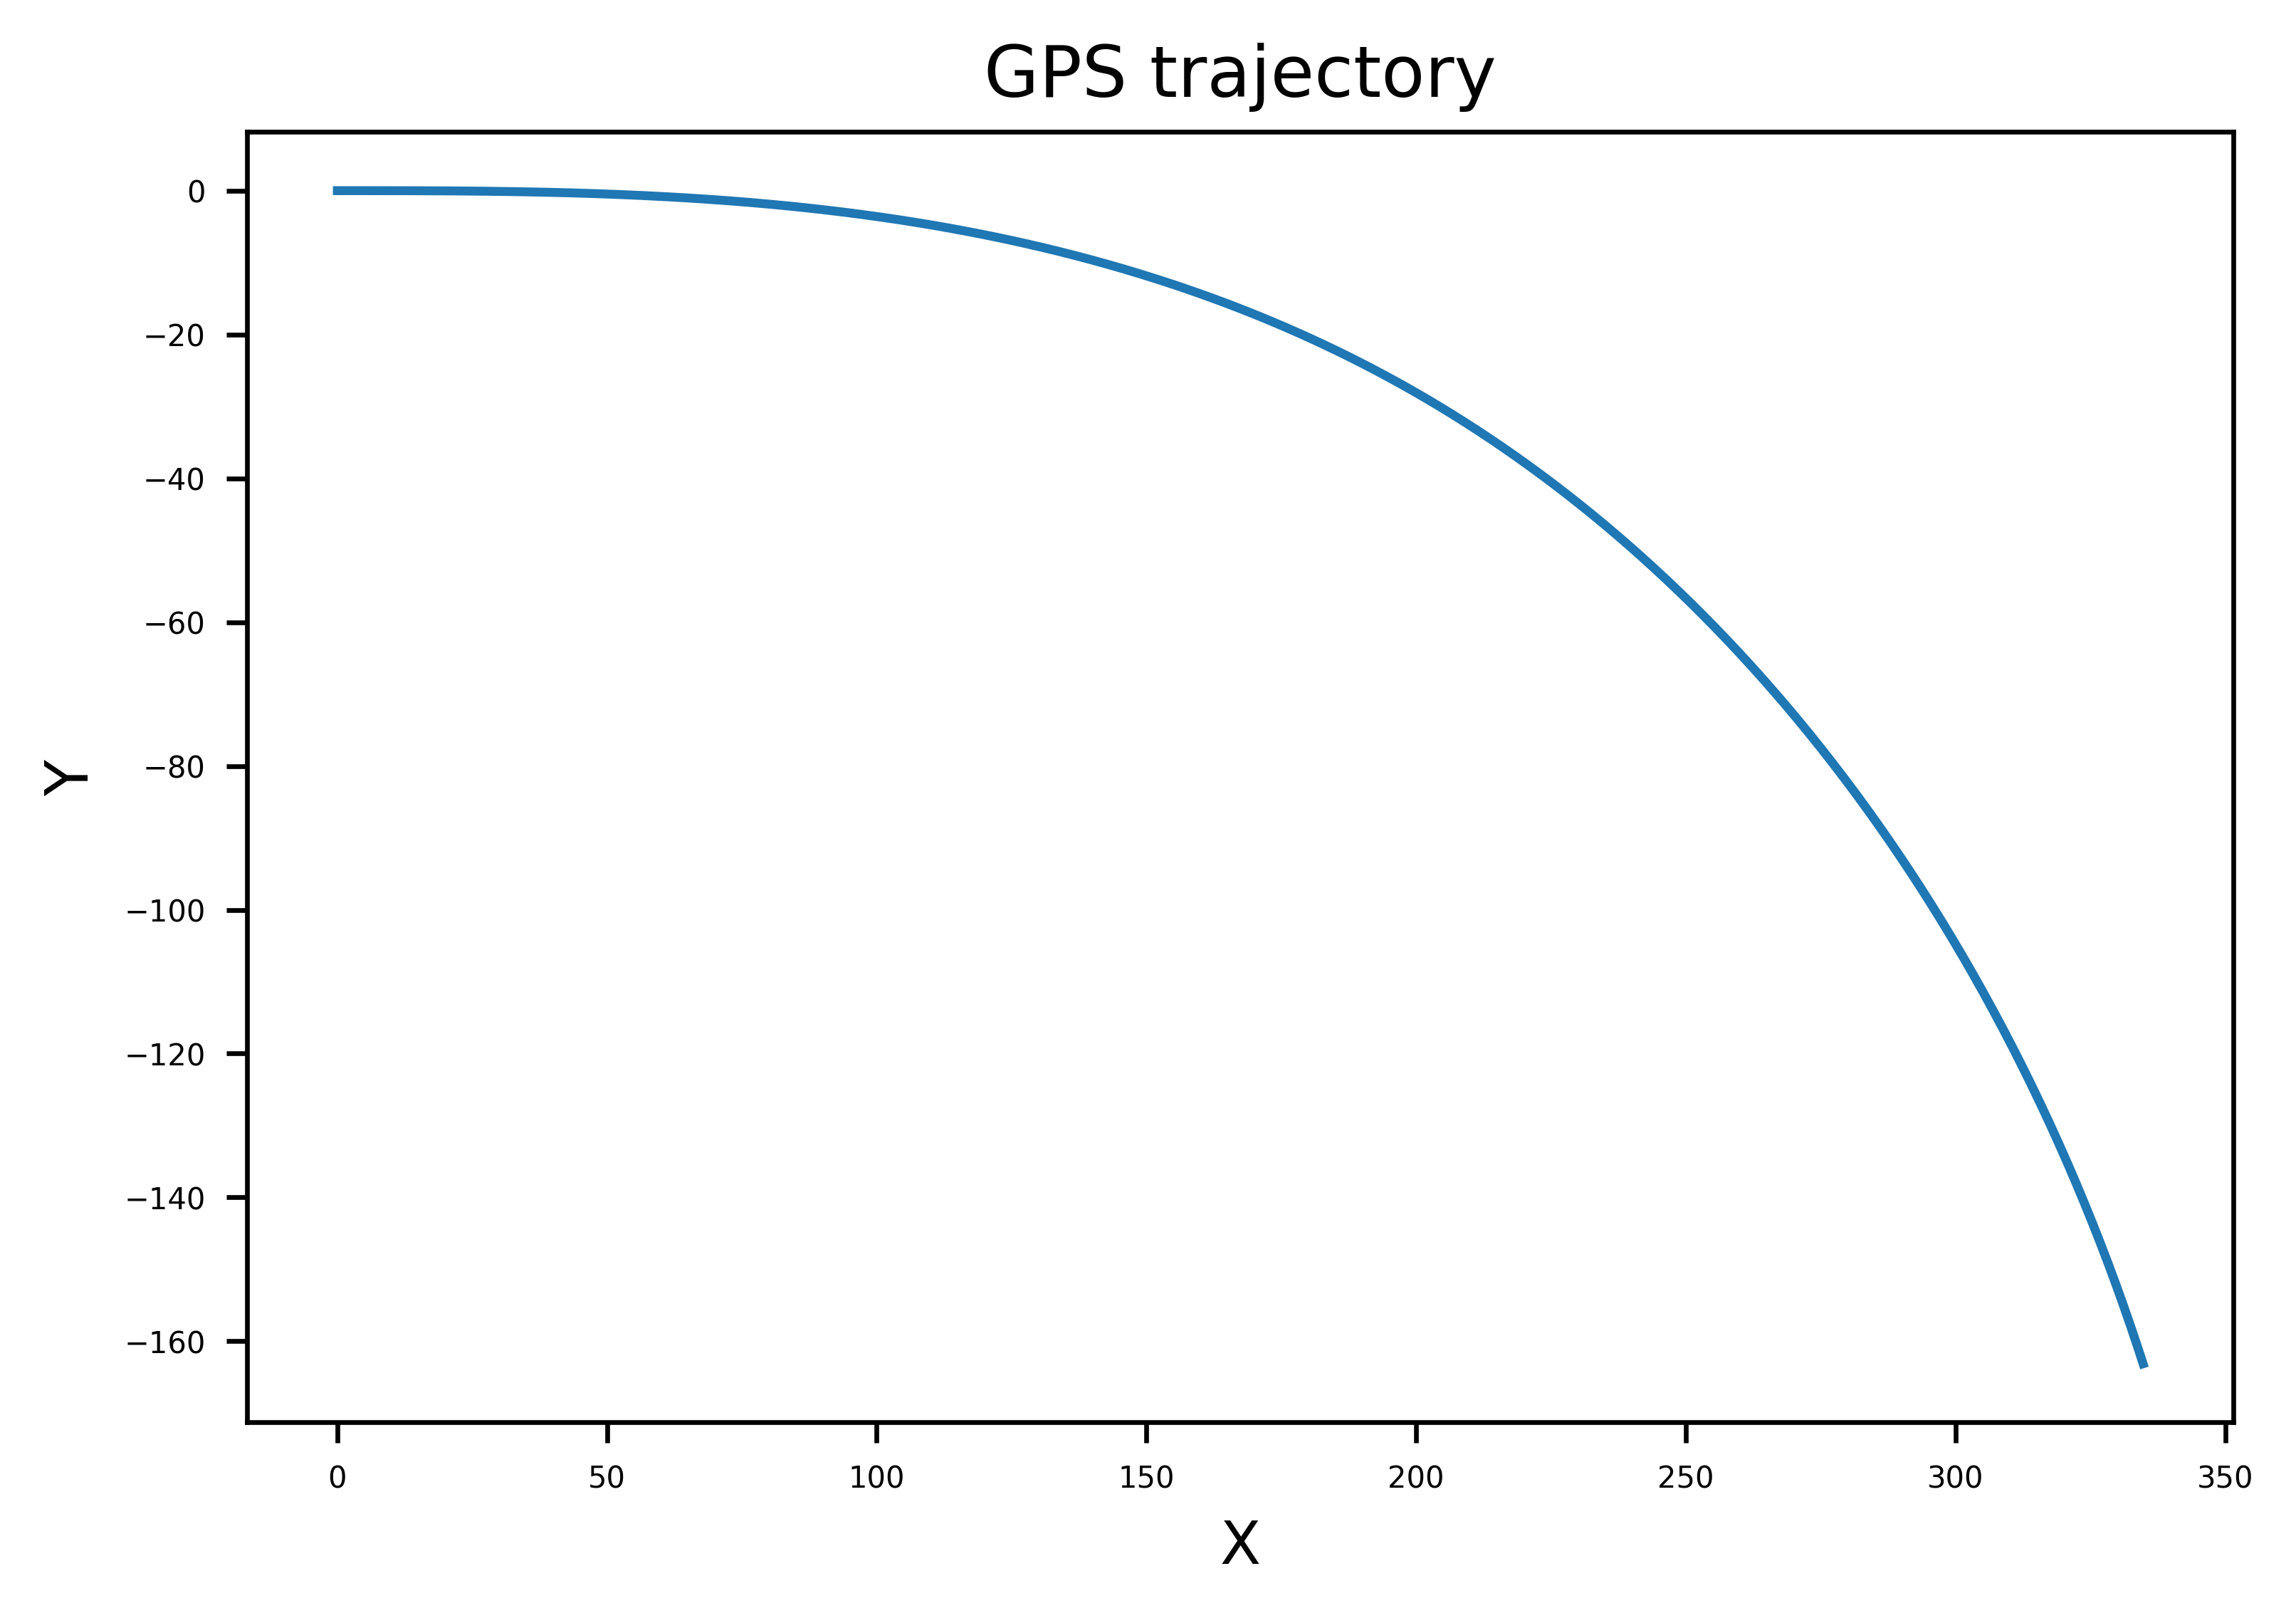

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
ax.set_title("GPS trajectory")
ax.plot(X, Y)
ax.set_ylabel("Y")
ax.set_xlabel("X");

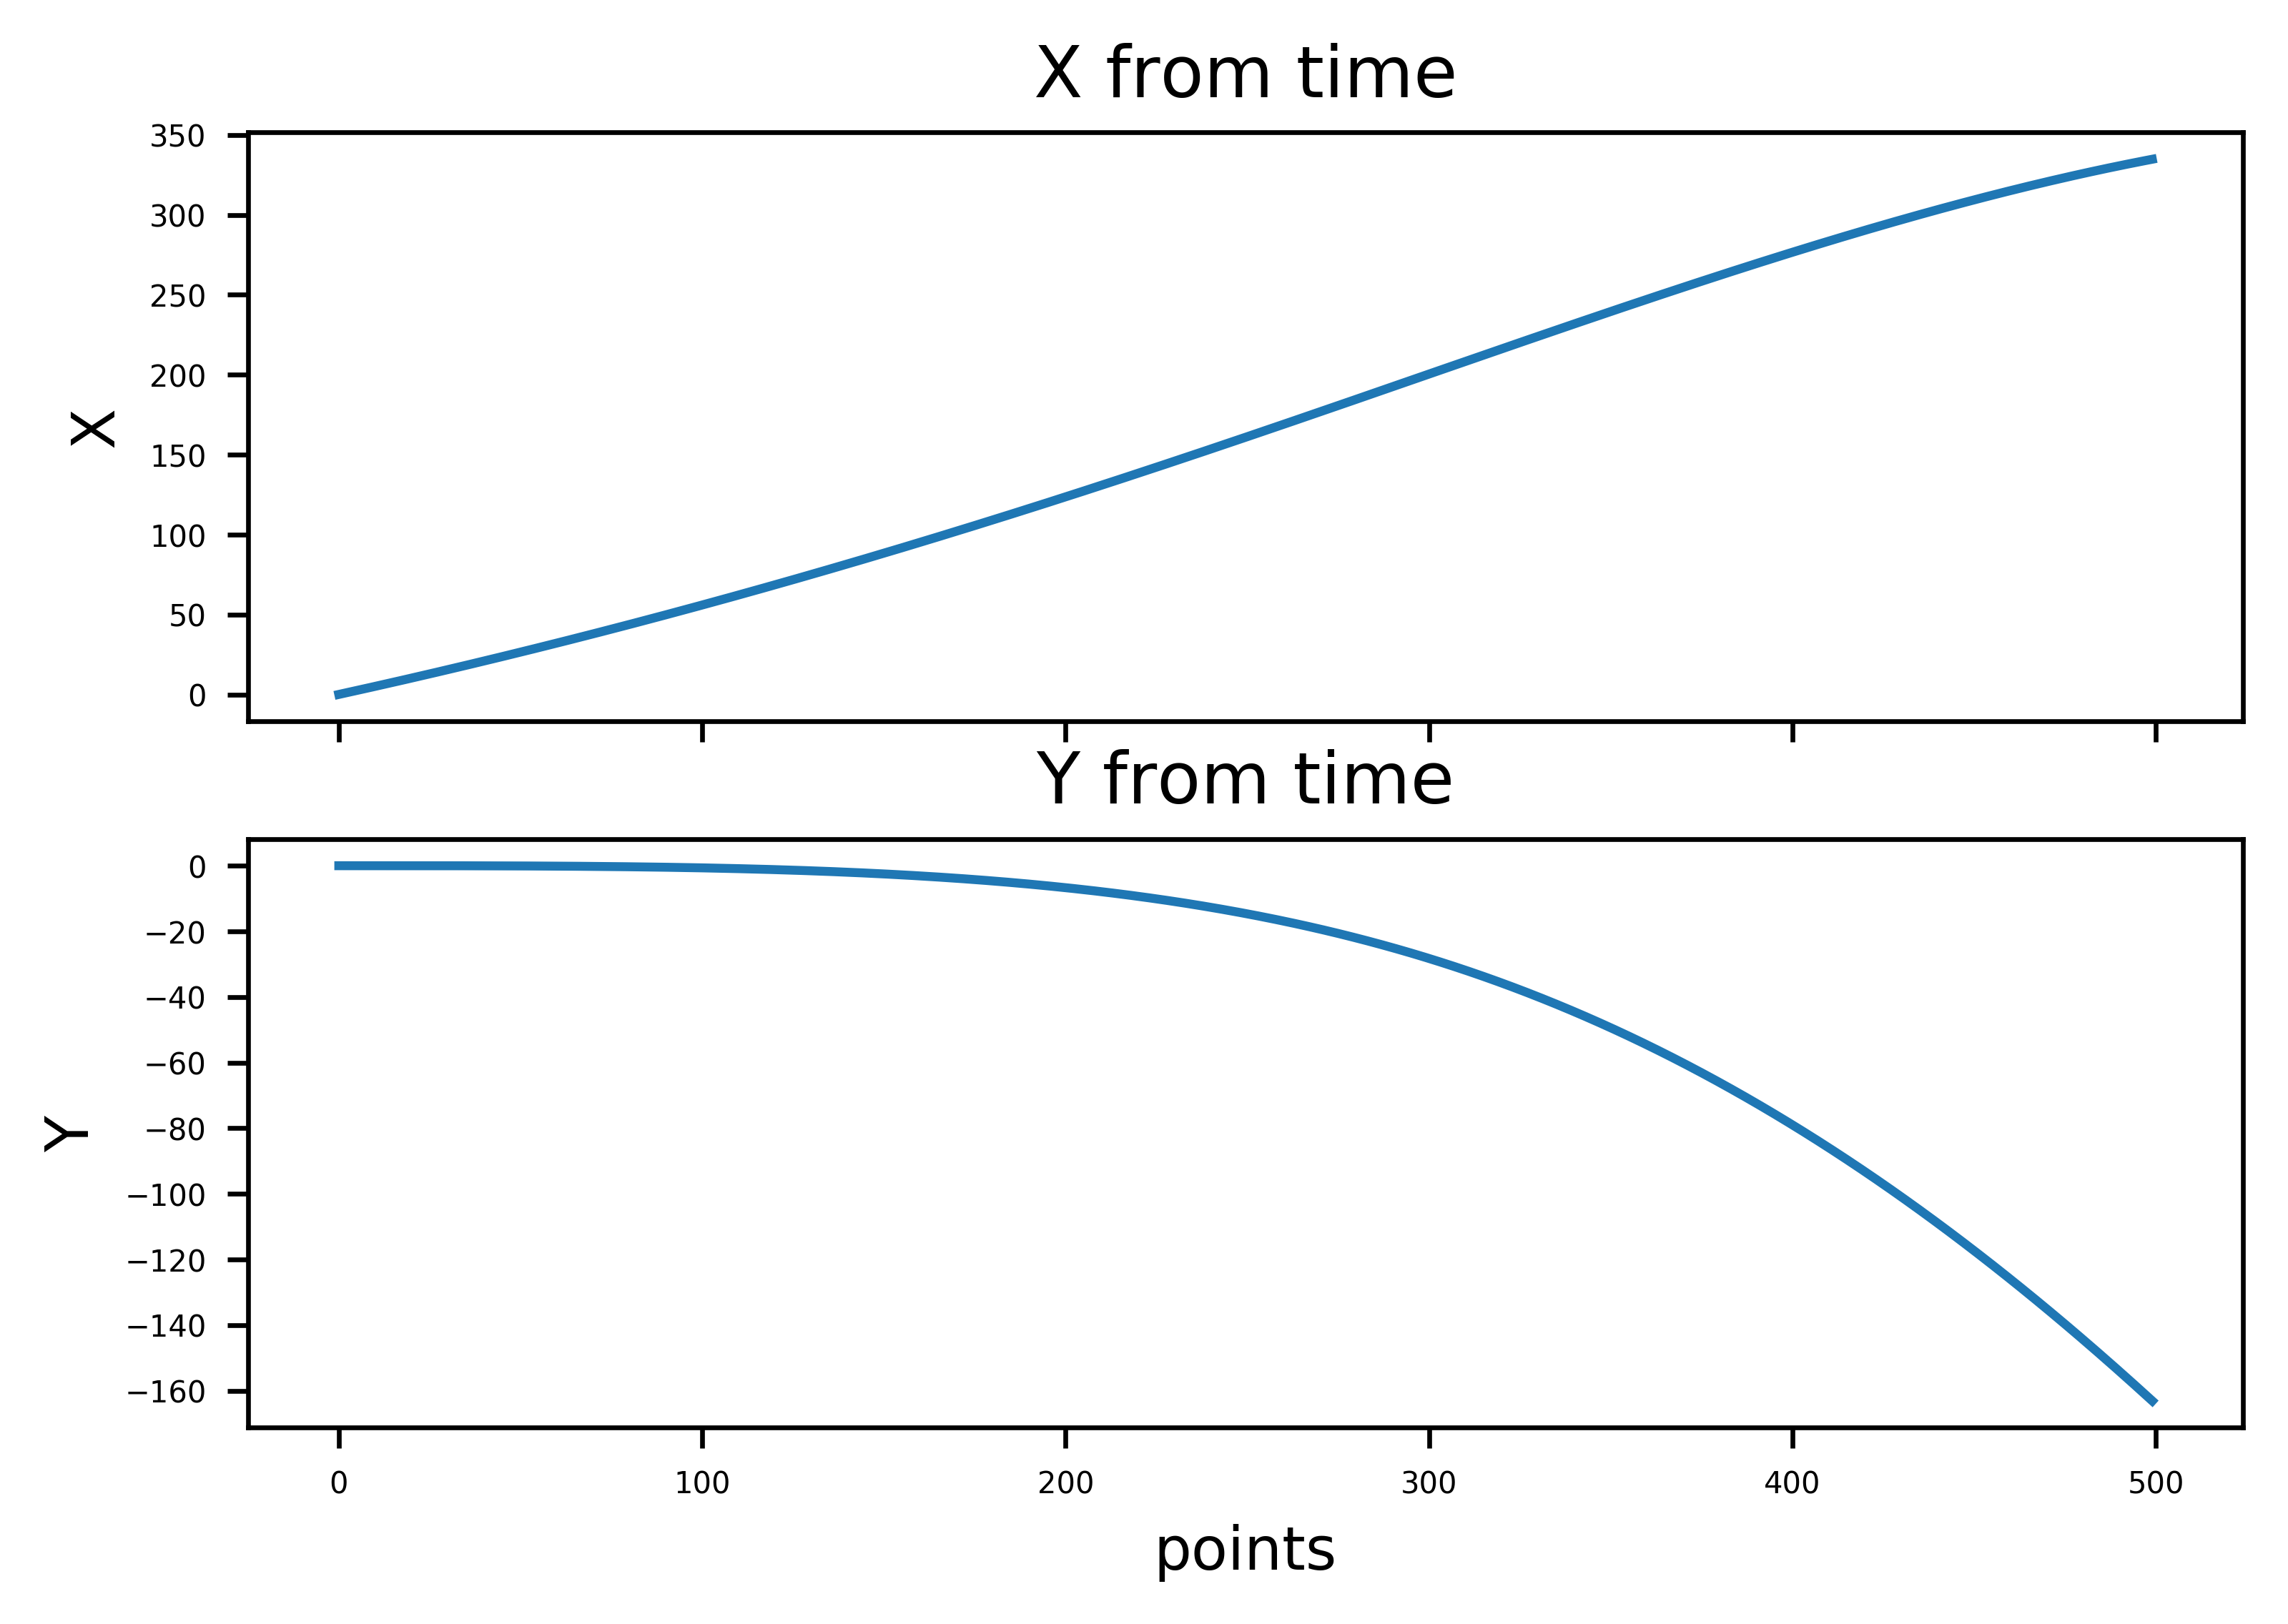

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), dpi=600, sharex=True)
ax[0].plot(X)
ax[0].set_title("X from time")
ax[0].set_ylabel("X")
ax[1].plot(Y)
ax[1].set_title("Y from time")
ax[1].set_ylabel("Y")
ax[1].set_xlabel("points")

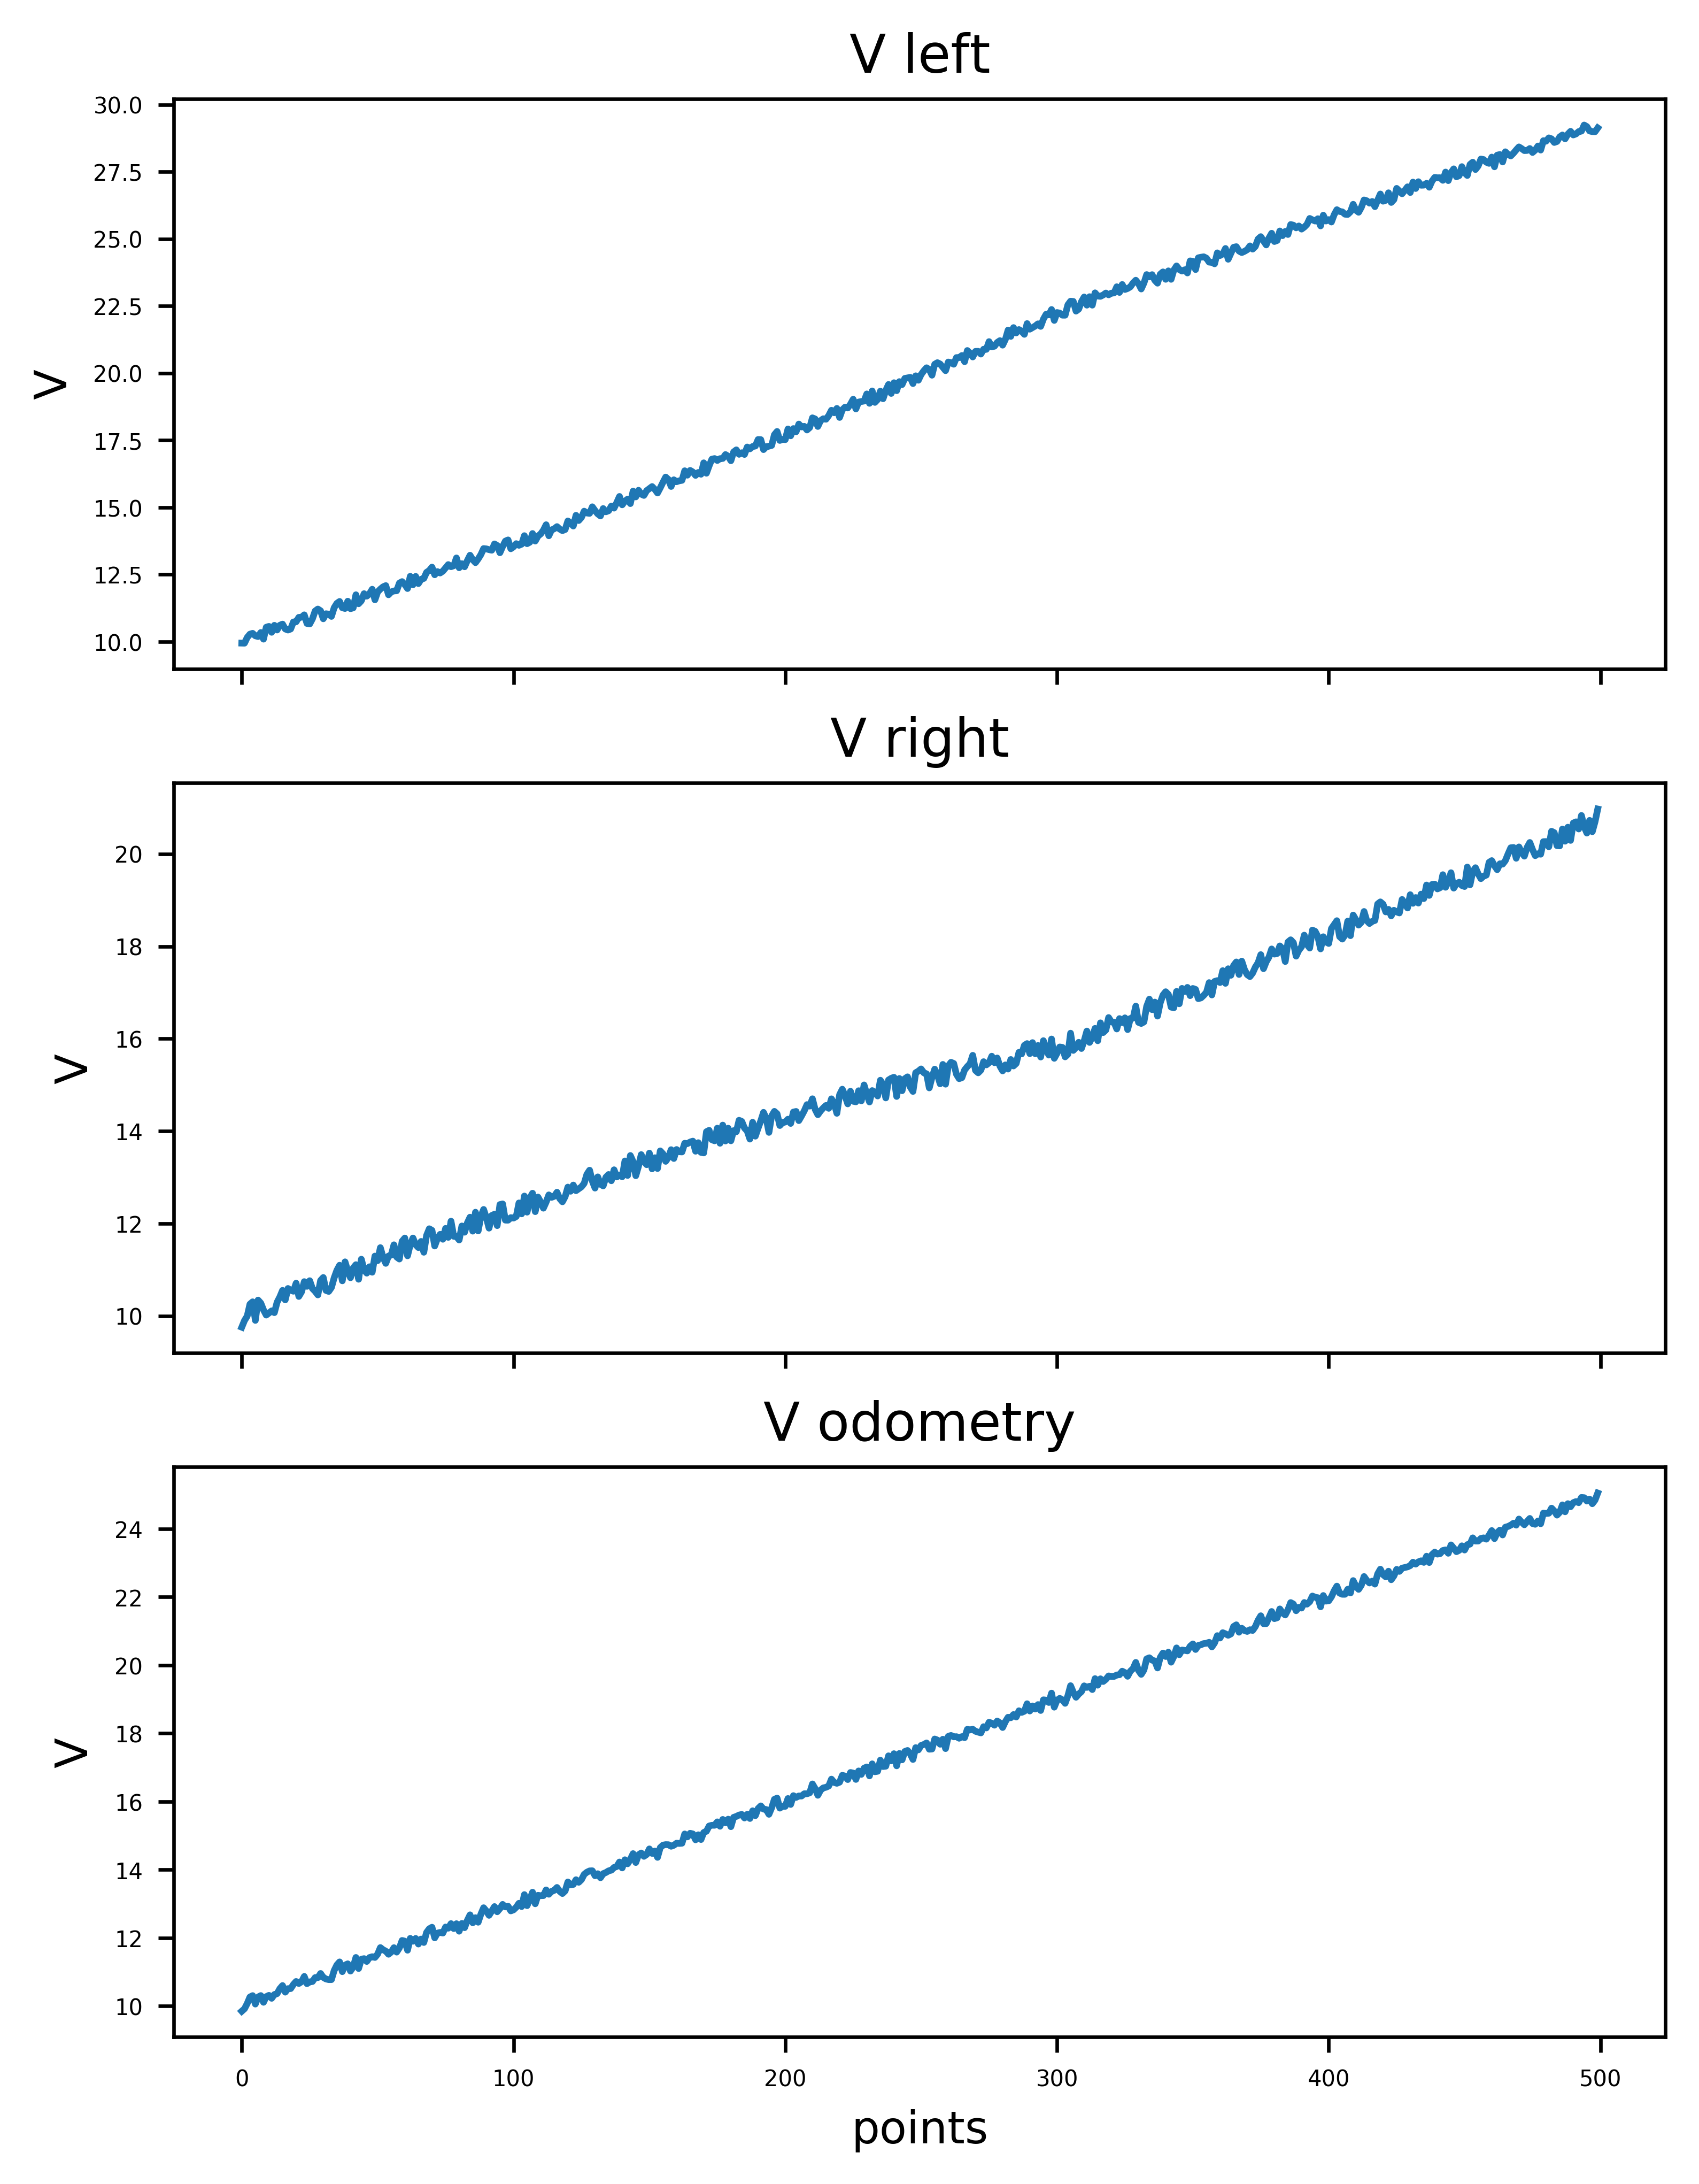

In [107]:
fig, ax = plt.subplots(3, 1, figsize=(6, 8), dpi=600, sharex=True)
ax[0].plot(V_left)
ax[0].set_title("V left")
ax[0].set_ylabel("V")
ax[1].plot(V_right)
ax[1].set_title("V right")
ax[1].set_ylabel("V")
ax[2].set_xlabel("points")
ax[2].plot(V_odom)
ax[2].set_title("V odometry")
ax[2].set_ylabel("V")

# Calculation of GPS velocity

In [117]:
def velocity_from_traj(x, t):
    v = (np.roll(x, -1) - np.roll(x, 1)) / 2 / t
    v[-1] = v[-2]
    v[0] = v[1]
    return v

t = 0.05
V_x = velocity_from_traj(X, t)
V_y = velocity_from_traj(Y, t)
V_GPS = (V_x ** 2 + V_y ** 2) ** 0.5

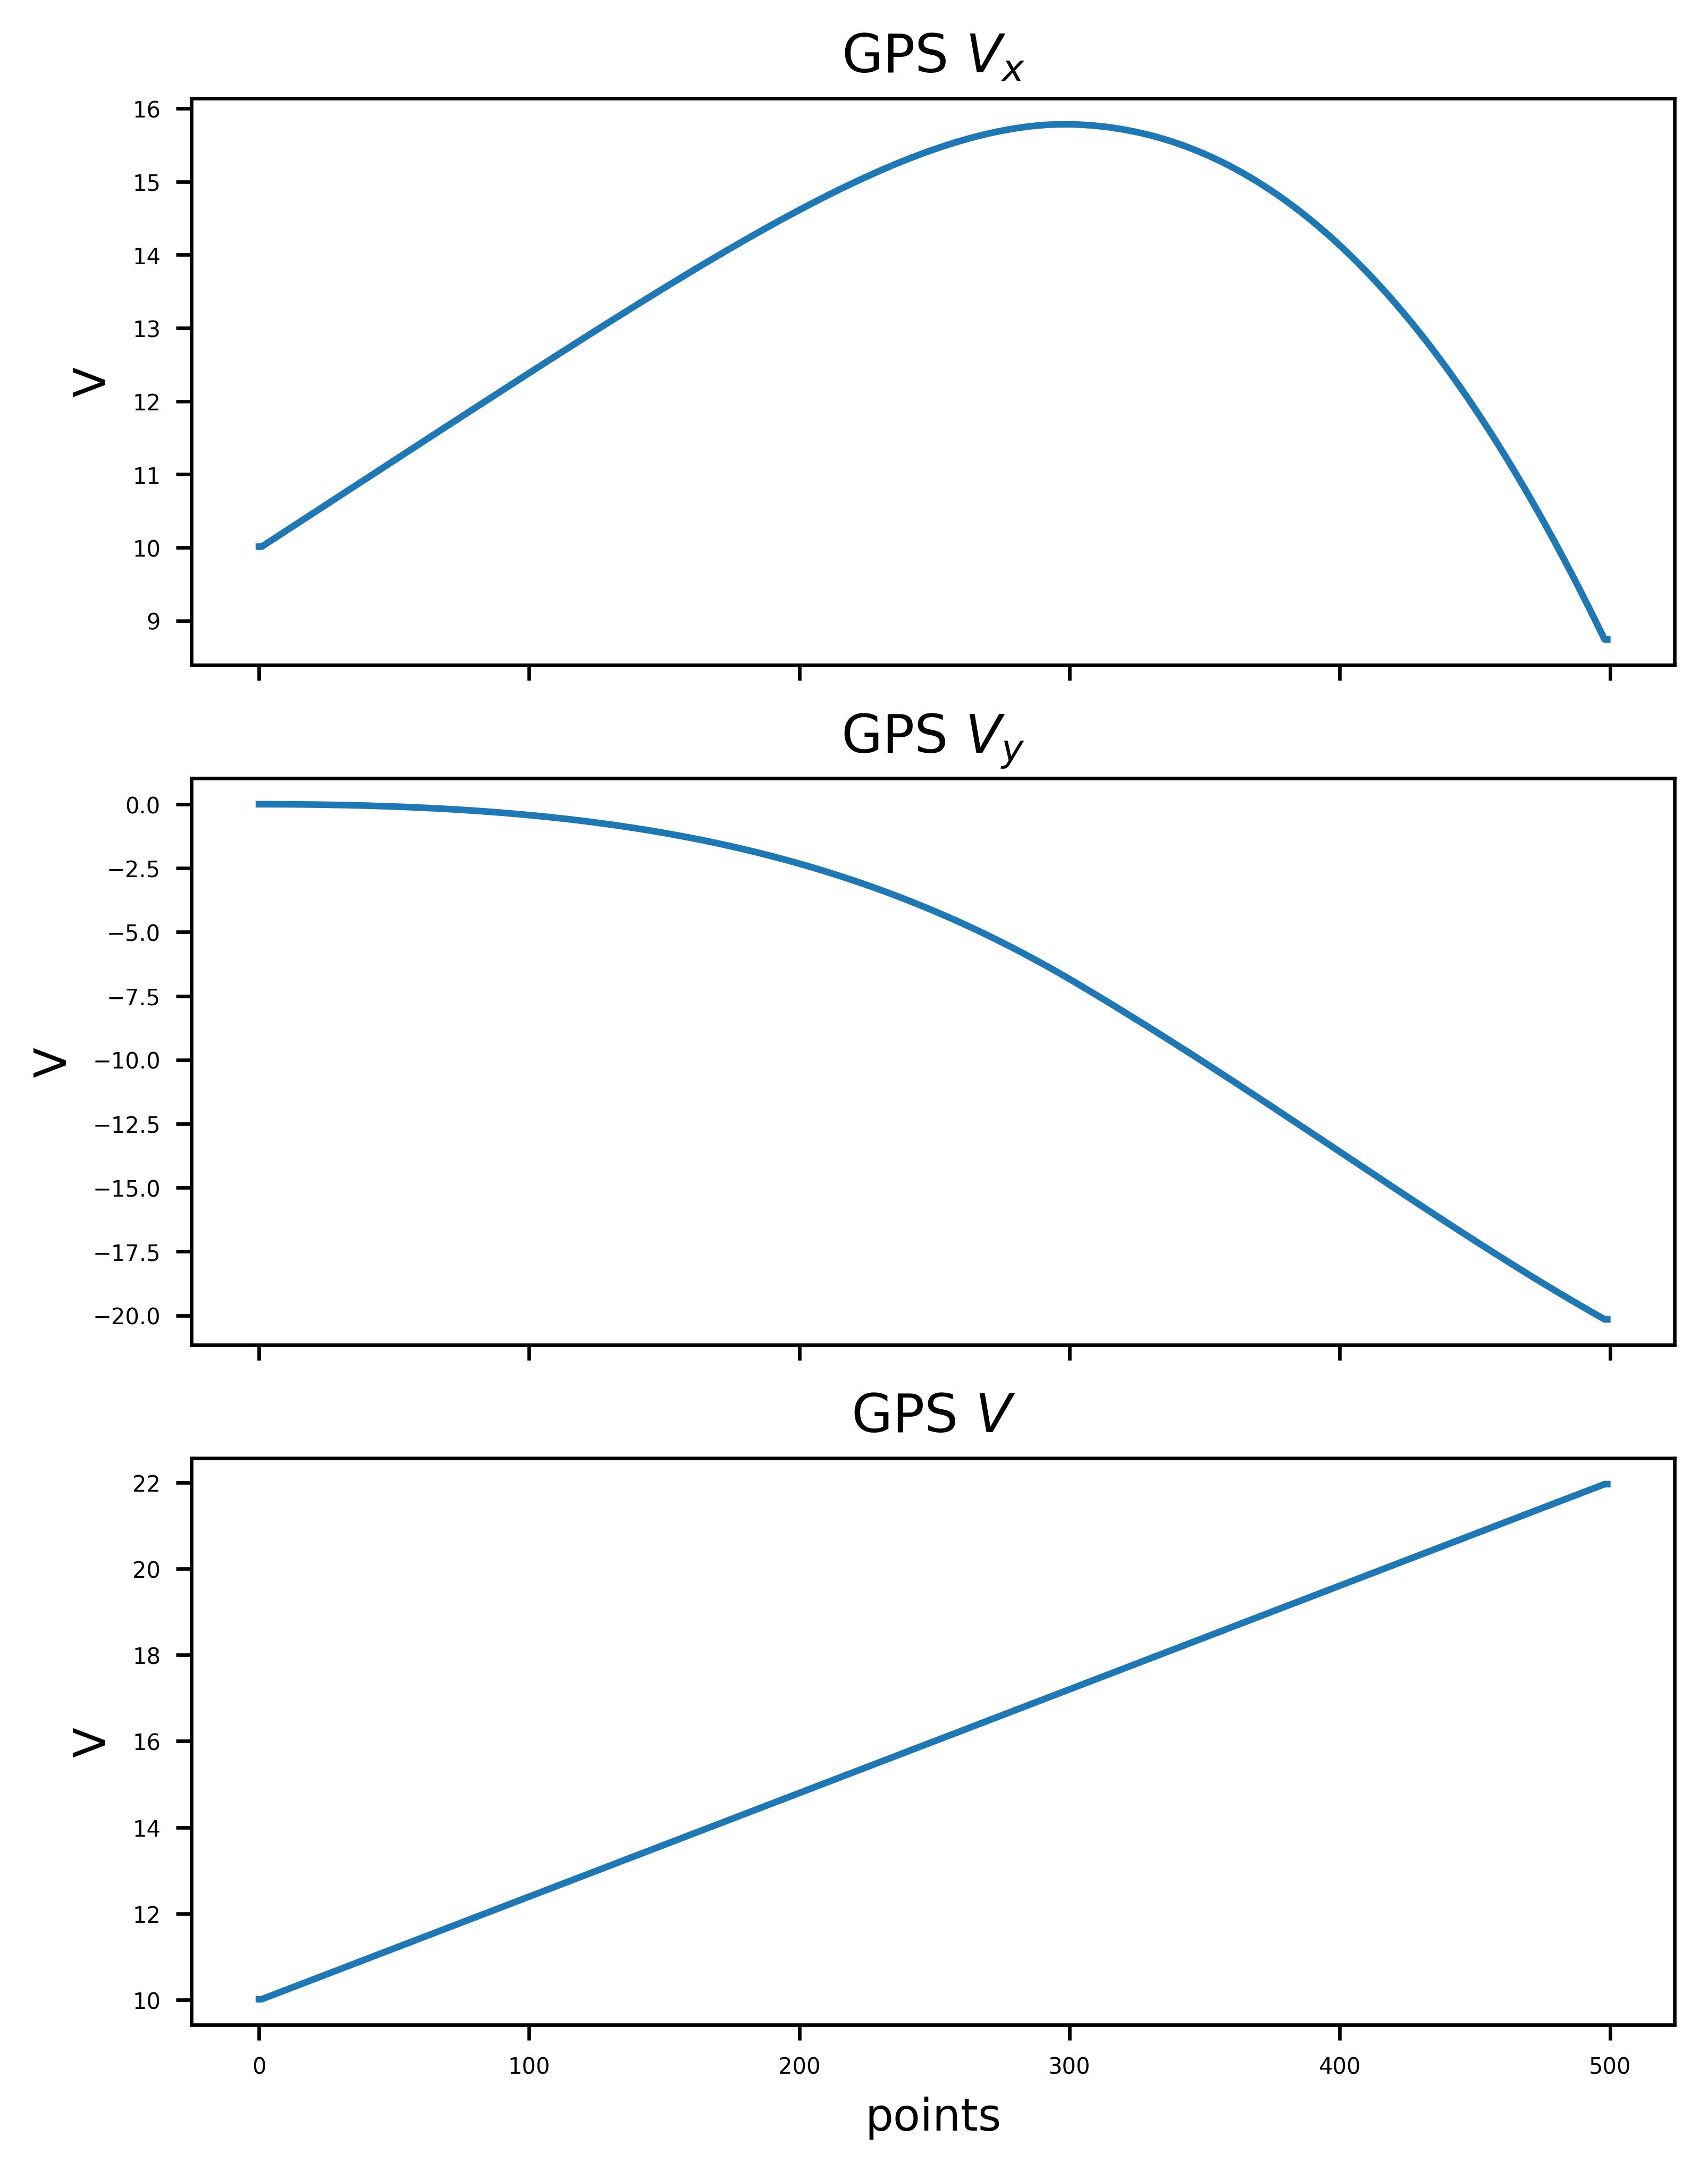

In [118]:
fig, ax = plt.subplots(3, 1, figsize=(6, 8), dpi=600, sharex=True)
ax[0].plot(V_x)
ax[0].set_title("GPS $V_x$")
ax[0].set_ylabel("V")
ax[1].plot(V_y)
ax[1].set_title("GPS $V_y$")
ax[1].set_ylabel("V")
ax[2].plot(V_GPS)
ax[2].set_title("GPS $V$")
ax[2].set_ylabel("V")
ax[2].set_xlabel("points")

# Simple 1-dim linear regression

In [113]:
y = V_GPS
x = V_odom

c1 = np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.sum((x - np.mean(x)) ** 2)
c0 = np.mean(y) - c1 * np.mean(x)
print("V_GPS = %f * V_odom + %f " % (c1, c0))
RMS = (np.sum((y - c1 * x - c0) ** 2) / (len(y) - 1)) ** 0.5
print("RMS = %f" % RMS)

V_GPS = 0.798858 * V_odom + 2.023108 
RMS = 0.085062


In [122]:
N = len(y)
F = np.array([y]).transpose()
R = np.array([np.ones(N), x]).transpose()
β = inv(R.transpose().dot(R)).dot(R.transpose().dot(F))
print(β)

[[ 2.02310771]
 [ 0.79885829]]


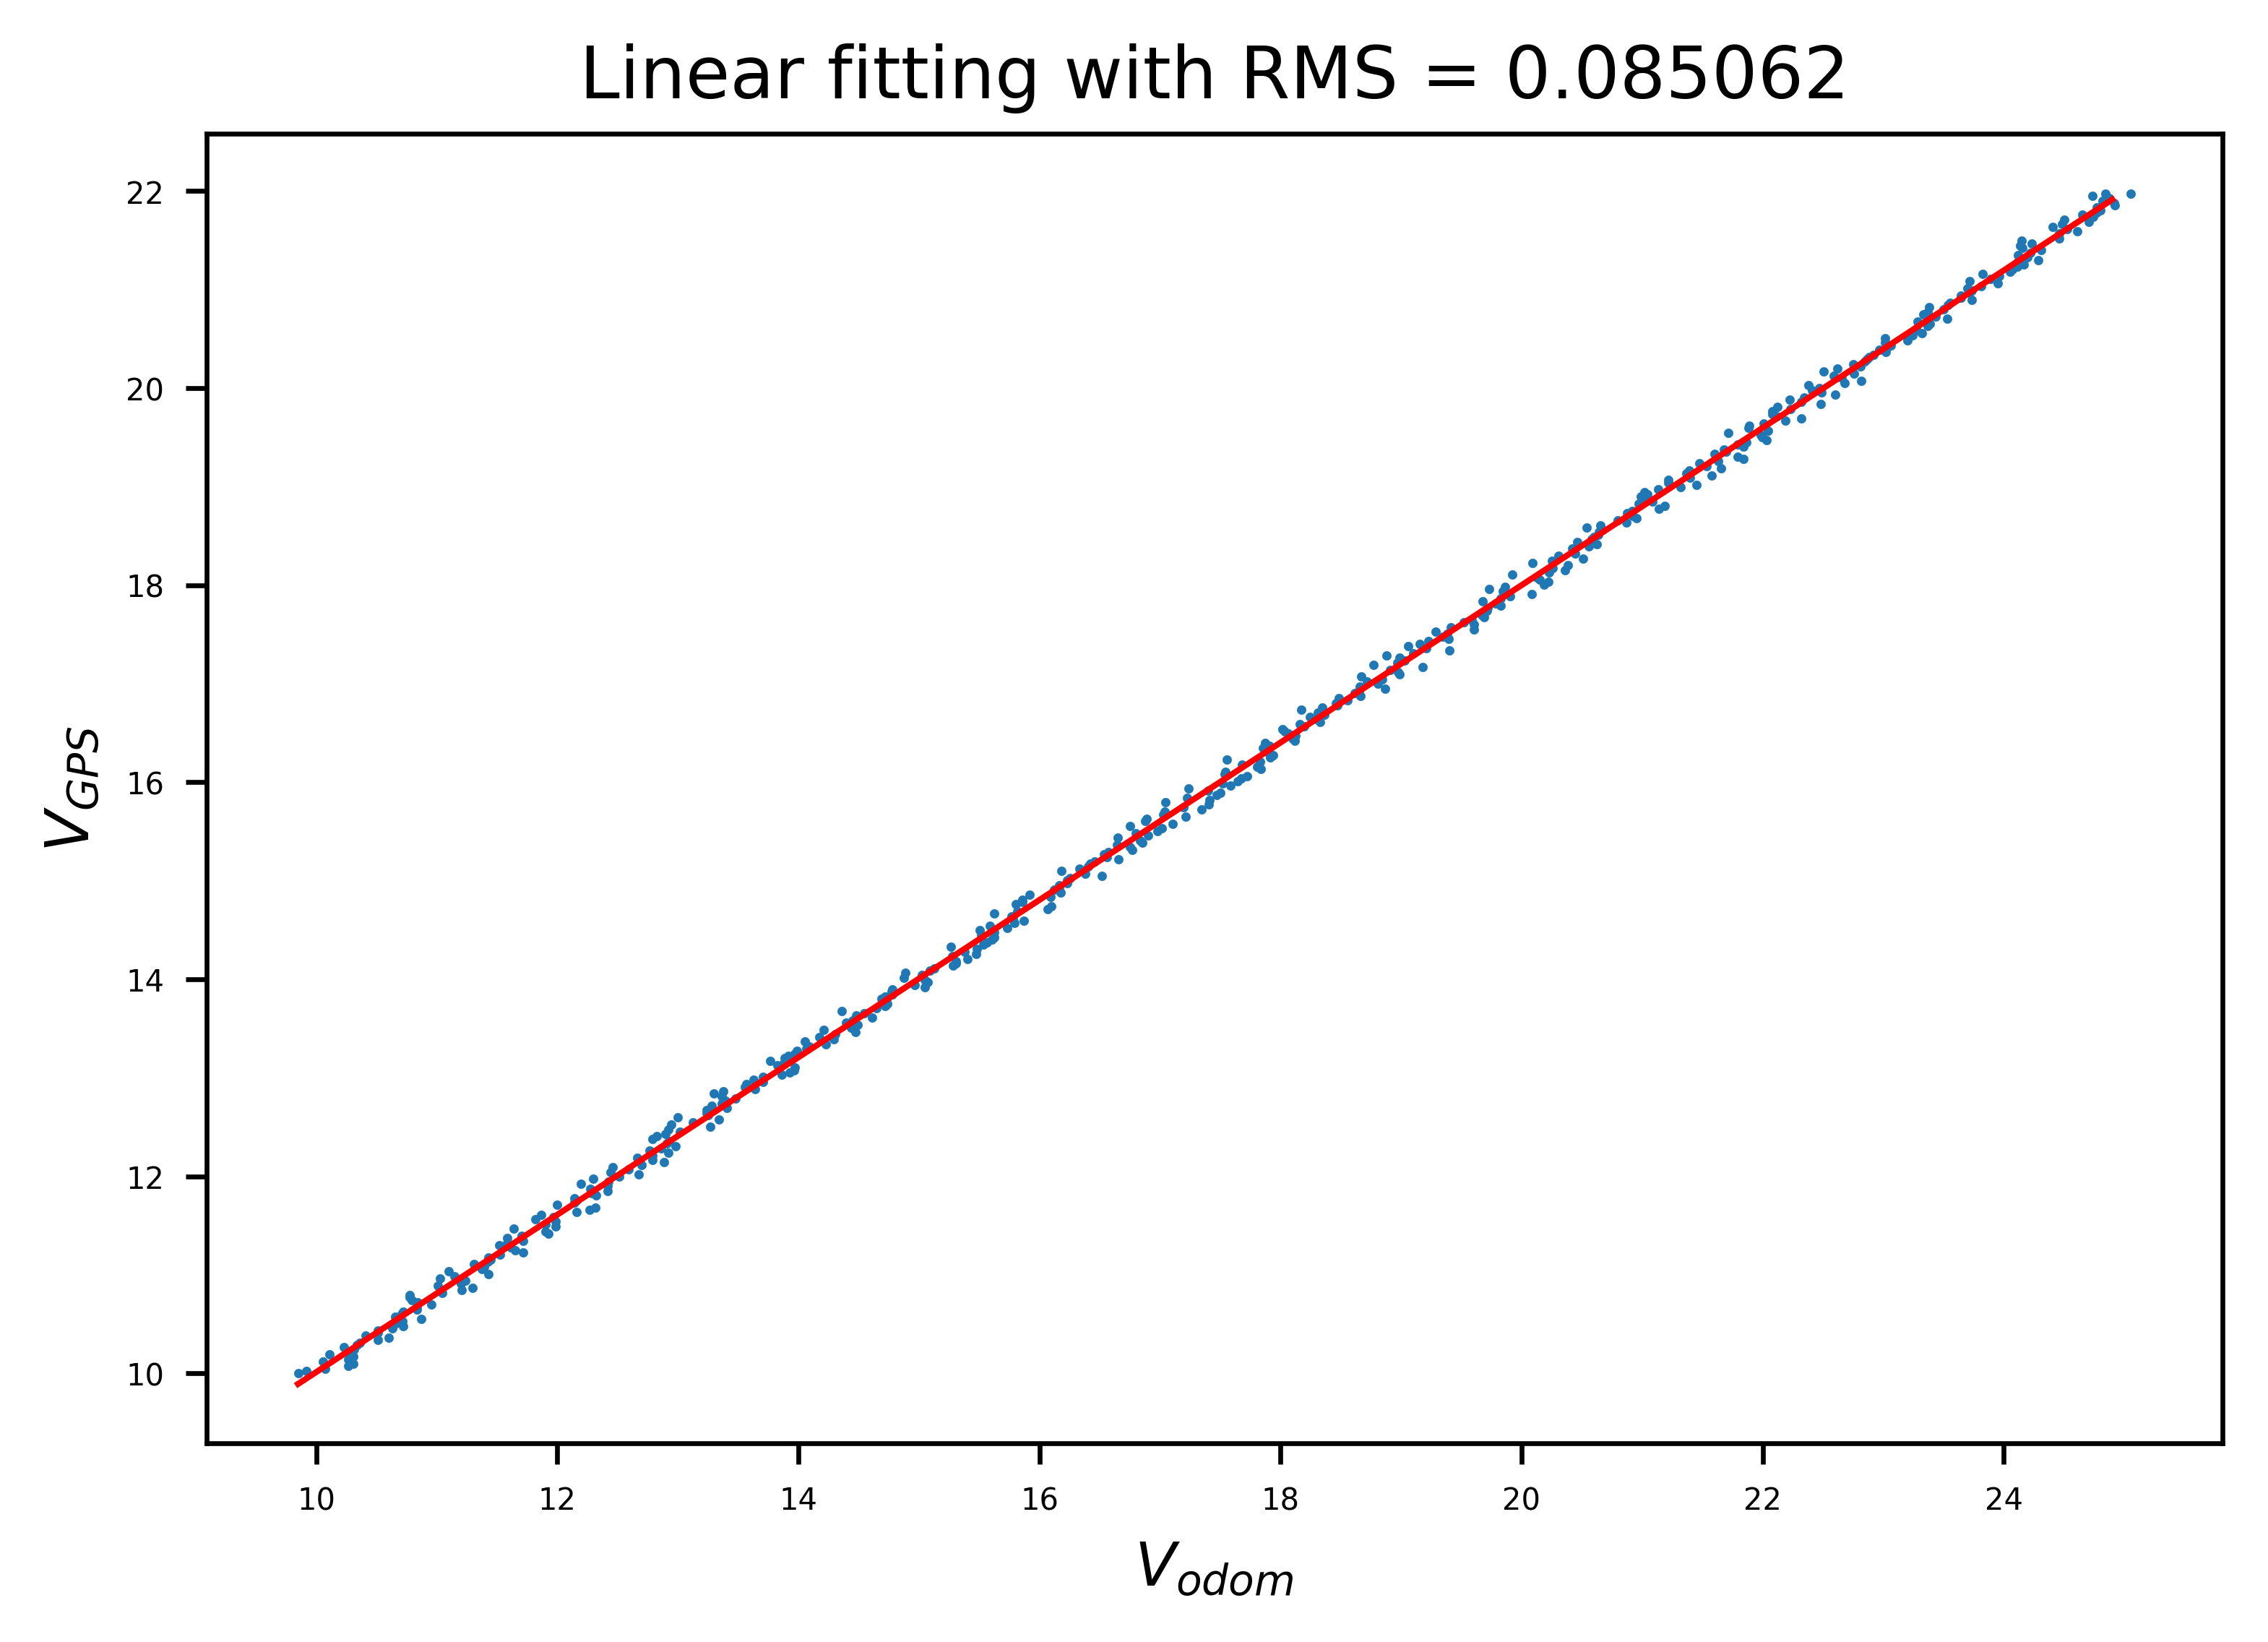

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=600)
ax.scatter(x, y, s=0.3)
x_line = np.arange(min(x), max(x), (max(x) - min(x)) /  100)
y_line = c0 + c1 * x_line
ax.plot(x_line, y_line, linewidth=1, color="r")
ax.set_xlabel("$V_{odom}$")
ax.set_ylabel("$V_{GPS}$")
ax.set_title("Linear fitting with RMS = %f" % RMS)